In [74]:
import pandas as pd
import numpy as np
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [75]:
file1 = "Resources/cleaned_winedf2.csv"
df = pd.read_csv(file1)

In [76]:
df = df.drop(columns=['description', 'province', 'region_1', 'region_2', 'variety', 'type', 'designation', "taster_twitter_handle", "title", 'winery'])
df = df.dropna(subset=['points', 'price'])
df = df[df['price'] < 1000]

### Per our exploratory analysis, we see that the strongest trend with "Price" is with Points, the Sommolier taster, and country. There were originally 42 different countries listed. We used https://winefolly.com/lifestyle/top-wine-regions-of-the-world/ in order to categorize the top wine regions in the world. This decreased the countries to 17 countries

In [77]:
file2 = "Resources/new_vs_old.csv"
df2 = pd.read_csv(file2)
df = pd.merge(df, df2, on="country")
df = df.dropna(subset=['taster_name'])
df = df.drop(columns=['country', 'old_vs_new', 'region'])
df

,points,price,taster_name,top_wine_regions
0,86,19,Mike DeSimone,others
2,87,19,Mike DeSimone,others
5,89,21,Mike DeSimone,others
8,89,33,Mike DeSimone,others
11,90,19,Mike DeSimone,others
...,...,...,...,...
378987,89,14,Mike DeSimone,others
378989,90,17,Mike DeSimone,others
378993,87,14,Mike DeSimone,others
378995,88,15,Mike DeSimone,others


# Data Pre-Processing

In [78]:
X = df[['points', 'taster_name', 'top_wine_regions']]
y = df['price'].values.reshape(-1, 1)
print(X.shape, y.shape)

(96404, 3) (96404, 1)


## Use Pandas get_dummies to Encode categorical values

### We want to add taster_name and top_wine_regions to our model. Since they are string values, we need to do encode those string values into an array of numerical values. In order to do this, we can either use OneHotEncoding or get_dummies that is a Pandas function. Since we are already dealing with a Pandas dataframe, it woudl take less code to use get_dummies in order to encode the values.

In [79]:
#Use Pandas get_dummies to encode taster_name and top_wine_regions
data = X.copy()

data_encoded = pd.get_dummies(data, columns=['taster_name', 'top_wine_regions'])
# data_encoded = pd.get_dummies(data, columns=['taster_name'])
# data_encoded = data
data_encoded.head()

,points,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jeff Jenssen,taster_name_Jim Gordon,taster_name_Joe Czerwinski,...,top_wine_regions_Greece,top_wine_regions_Hungary,top_wine_regions_Italy,top_wine_regions_New Zealand,top_wine_regions_Portugal,top_wine_regions_Romania,top_wine_regions_South Africa,top_wine_regions_Spain,top_wine_regions_US,top_wine_regions_others
0,86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,87,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### We already took out some of the outliers by narrowing down the DataFrame by filtering out any wines that are priced over $1,000. Lets graph points vs price

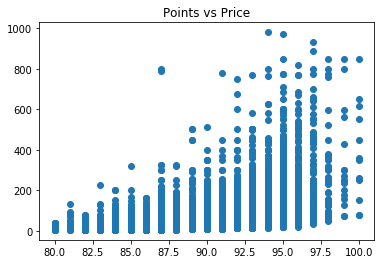

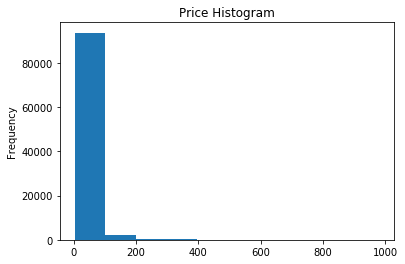

In [80]:
plt.scatter(df['points'], y)
plt.title("Points vs Price")
plt.show()
df.price.plot.hist()
plt.title('Price Histogram')
plt.show()
# df.points.plot.hist()

In [81]:
data.head()

,points,taster_name,top_wine_regions
0,86,Mike DeSimone,others
2,87,Mike DeSimone,others
5,89,Mike DeSimone,others
8,89,Mike DeSimone,others
11,90,Mike DeSimone,others


### We see that there is a linear correlation between points and price. However, when looking at the numerical distribution, we see that it is positively skewed. This fits a Box-Cox transformation in Scikit. We are using a PowerTransformer function to transform the price in order to use more evenly distributed data for our model. 

In [82]:
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
X_lognormal = y
price_transformed = pt.fit_transform(X_lognormal)
# X_lognormal
price_transformed

array([[1.90685074],
       [1.90685074],
       [1.94523436],
       ...,
       [1.78183614],
       [1.81115771],
       [1.83800622]])

In [83]:
price_transformed = pd.DataFrame(price_transformed)

In [84]:
data_encoded = data_encoded.reset_index(drop=True)
price_transformed = price_transformed.reset_index(drop=True)

In [85]:
data_encoded = pd.concat([data_encoded, price_transformed], axis=1)
# data_encoded

In [86]:
data_encoded = data_encoded.rename(columns={0: 'price_transformed'})
# data_encoded.columns

### Lets graph our newly transformed Price to see if its more evenly distributed along with a stronger linearregression.

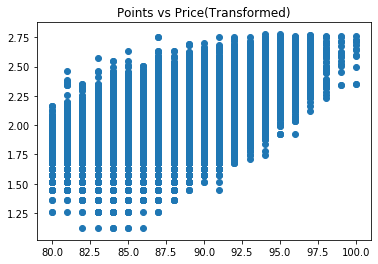

In [87]:
plt.scatter(data_encoded.points, data_encoded.price_transformed)
plt.title('Points vs Price(Transformed)')
plt.show()

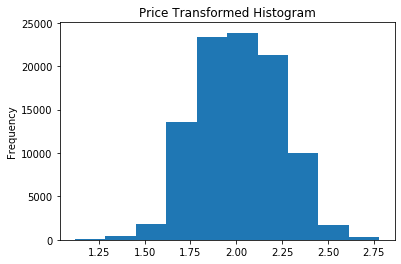

In [88]:
#Run histogram on new transformed Price
data_encoded.price_transformed.plot.hist()
plt.title('Price Transformed Histogram')
plt.show()

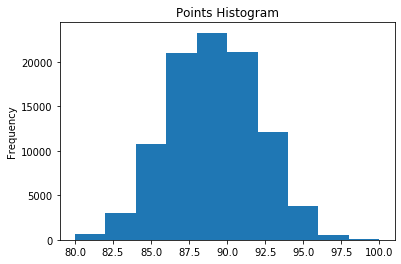

In [89]:
data_encoded.points.plot.hist()
plt.title('Points Histogram')
plt.show()

### Now that we know our price is transformed and evenly distrbuted, it is time to run our Model. 

In [90]:
X = data_encoded.drop(['price_transformed'], axis='columns')
# X = data_encoded.drop(['price_transformed', 'top_wine_regions', 'taster_name'], axis='columns')
y = data_encoded.price_transformed.values.reshape(-1,1)
print(X.shape, y.shape)

(96404, 37) (96404, 1)


In [91]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(X, y)
# model.fit(X_train_scaled, y_train_scaled)
model.score(X, y)

0.4607121015106825

In [92]:
import numpy as np
from scipy import log
import statsmodels.api as sm
X = sm.add_constant(X)
# X = data_encoded.points
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     2353.
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        18:57:06   Log-Likelihood:                 38647.
No. Observations:               96404   AIC:                        -7.722e+04
Df Residuals:                   96368   BIC:                        -7.688e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [94]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [95]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

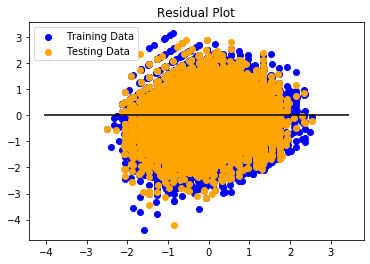

In [97]:
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [98]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5291088356334623, R2: 0.4627035384931763


# Perform Model for Single Country - US

### Let's attempt to see if we get a higher level of predictability if we are able to narrow down our data to a single country. Most countries have only 1 taster, so we are going to use US as that example. 

In [72]:
us = df[df['top_wine_regions'] == 'US'] 
us = pd.get_dummies(us, columns=['taster_name'])

us.head()

,points,price,top_wine_regions,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jim Gordon,taster_name_Joe Czerwinski,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone
270,85,75,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
272,81,24,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279,84,30,US,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
281,86,28,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
285,86,34,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


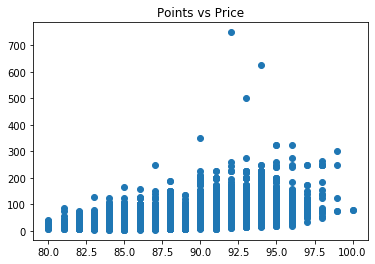

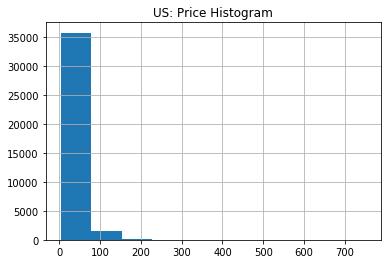

In [73]:
#Plot points and price for US data
plt.scatter(us['points'], us['price'])
plt.title("Points vs Price")
plt.show()

us.price.hist()
plt.title('US: Price Histogram')
plt.show()


### We see that the price is once again positively skewed. Lets run the same Box-Cox transformation in order see the distribution we need to run the Model.

In [64]:
#Run Box-Cox transformation with PowerTransformer
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
y_lognormal = us.price.values.reshape(-1,1)
us_price_transformed = pt.fit_transform(y_lognormal)
us_price_transformed = pd.DataFrame(us_price_transformed)

In [65]:
us_price_transformed

,0
0,3.348252
1,2.629650
2,2.778434
3,2.732868
4,2.860115
...,...
37505,2.778434
37506,2.778434
37507,2.431696
37508,2.878853


In [66]:
us_enc = us.drop(['price', 'top_wine_regions'], axis='columns').reset_index(drop=True)
us_enc = pd.concat([us_enc, us_price_transformed], axis=1)
us_enc = us_enc.rename(columns={0: 'price_transformed'})
us_enc
# data_encoded = pd.concat([data_encoded, price_transformed], axis=1)

,points,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jim Gordon,taster_name_Joe Czerwinski,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone,price_transformed
0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.348252
1,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.629650
2,84,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.778434
3,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.732868
4,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.860115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37505,87,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.778434
37506,88,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.778434
37507,89,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.431696
37508,90,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.878853


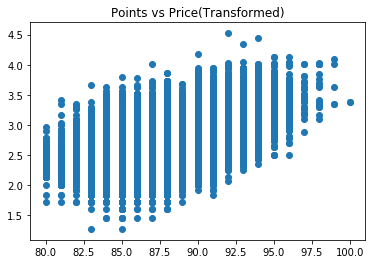

In [67]:
plt.scatter(us_enc.points, us_enc.price_transformed)
plt.title('Points vs Price(Transformed)')
plt.show()

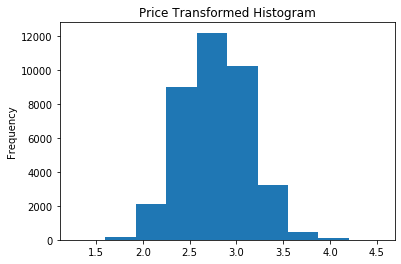

In [68]:
#Run histogram on new transformed Price
us_enc.price_transformed.plot.hist()
plt.title('Price Transformed Histogram')
plt.show()

In [69]:
X = us_enc.drop(['price_transformed', 'points'], axis='columns')
y = us_enc.price_transformed.values.reshape(-1,1)
print(X.shape, y.shape)

(37510, 15) (37510, 1)


In [70]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(X, y)
# model.fit(X_train_scaled, y_train_scaled)
model.score(X, y)

0.12257212367334602

### Unfortunately in this model, we are only receiving a 12% probabilty rather than the 46% when we run the global dataset. 

In [71]:
import numpy as np
from scipy import log
import statsmodels.api as sm
X = sm.add_constant(X)
# X = data_encoded.points
mod = sm.OLS(y, X)
res = mod.fit()
print('Model Results: ')
print(res.summary())

Model Results: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     374.0
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        18:40:19   Log-Likelihood:                -12921.
No. Observations:               37510   AIC:                         2.587e+04
Df Residuals:                   37495   BIC:                         2.600e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------